# Glicko-2 Prompt-Completion Pair Statistics

---

!pip install glicko2
!pip install -U datasets

In [1]:
# -*- coding: utf-8 -*-
import time
import math
from collections import defaultdict
from datetime import datetime
import pandas as pd
from datasets import load_dataset, IterableDataset, concatenate_datasets, Dataset # Make sure IterableDataset is imported if using streaming
from glicko2 import Player
import re
import datasets
import matplotlib.pyplot as plt
import numpy as np


In [2]:
d = load_dataset("Columbia-NLP/DPO-tldr-summarisation-preferences") # Disable caching
train = d['train']
val = d['validation']
test = d['test']
dataset = train.add_column("sub_reddit", [x['subreddit'] for x in train['other_info']])
dataset_test = val.add_column("sub_reddit", [x['subreddit'] for x in val['other_info']])
dataset_eval = test.add_column("sub_reddit", [x['subreddit'] for x in test['other_info']])

In [48]:
df = dataset.to_pandas()

In [49]:
df['chosen'] = [x[1]['content'] for x in df['chosen']]
d1 = df[['prompt', 'chosen', 'sub_reddit']]
df['reject'] = [x[1]['content'] for x in df['rejected']]
d2 = df[['prompt', 'reject', 'sub_reddit']]
d2 = d2.rename(columns = {'reject': 'chosen'})
df = pd.concat([d1, d2], ignore_index=True)

In [52]:
train_sr = ['AskDocs', 'legaladvice', 'Advice', 'askwomenadvice', 'AskReddit', 'needadvice', 'relationship_advice', 'dating_advice' ]
test_sr = ['running','Cooking']

In [54]:
pair_counts = df.loc[df['sub_reddit'].isin(train_sr)][['prompt', 'chosen']].value_counts()
pair_counts_df = pair_counts.reset_index(name='count')

(array([3.3700e+02, 1.0606e+04, 6.2340e+03, 2.3500e+02, 3.8000e+01,
        1.4100e+02, 8.0000e+00, 9.3000e+01, 1.9000e+01, 3.0000e+00,
        1.1000e+01, 2.3000e+01, 1.0000e+00, 2.4000e+01, 7.0000e+00,
        4.0000e+01, 4.0000e+00, 1.3000e+01, 0.0000e+00, 2.0000e+00,
        7.0000e+00, 9.0000e+00, 4.0000e+00, 2.3000e+01, 2.0000e+00,
        1.7000e+01, 8.0000e+00, 1.3000e+01, 3.0000e+00, 1.8000e+01,
        1.0000e+00, 6.0000e+00, 0.0000e+00, 1.3000e+01, 6.0000e+00,
        8.0000e+00, 9.0000e+00, 1.5000e+01, 5.0000e+00, 5.0000e+00,
        5.0000e+00, 1.9000e+01, 7.0000e+00, 2.4000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.]),
 <BarContainer object of 50 a

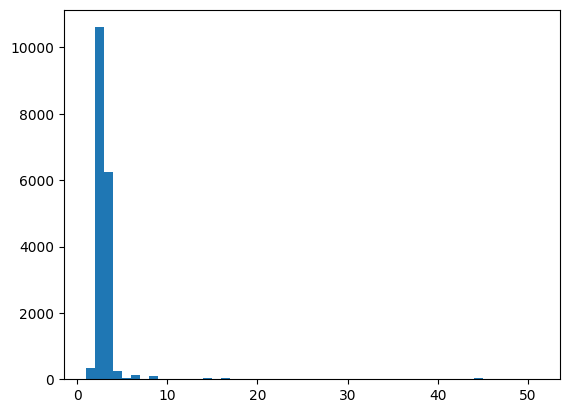

In [55]:
plt.hist(pair_counts_df['count'], bins = range(1, 52))

In [ ]:
df['sub_reddit'].unique()

array(['AskReddit', 'tifu', 'relationships', 'dating_advice', 'Advice',
       'jobs', 'cats', 'travel', 'personalfinance', 'relationship_advice',
       'askwomenadvice', 'Pets', 'loseit', 'Dogtraining', 'Cooking',
       'legaladvice', 'running', 'offmychest', 'Parenting', 'dogs',
       'BreakUps', 'self', 'weddingplanning', 'AskDocs', 'needadvice',
       'books', 'GetMotivated', 'pettyrevenge', 'college'], dtype=object)

In [ ]:
train_sr = ['AskDocs', 'legaladvice', 'Advice', 'askwomenadvice', 'AskReddit', 'needadvice', 'relationship_advice', 'dating_advice' ]
test_sr = ['running','Cooking']
train_df = df.loc[ df['sub_reddit'].isin(train_sr)]
test_df = df.loc[ df['sub_reddit'].isin(test_sr)]
dataset = Dataset.from_pandas(train_df)

In [ ]:
train_df.describe()

,score_chosen,score_rejected
count,27000.0,27000.0
mean,10.0,1.0
std,0.0,0.0
min,10.0,1.0
25%,10.0,1.0
50%,10.0,1.0
75%,10.0,1.0
max,10.0,1.0


In [ ]:
test_df.describe()

,score_chosen,score_rejected
count,524.0,524.0
mean,10.0,1.0
std,0.0,0.0
min,10.0,1.0
25%,10.0,1.0
50%,10.0,1.0
75%,10.0,1.0
max,10.0,1.0


In [ ]:
test_df['prompt'].iloc[500]

'You are an AI assistant good at summarizing reddit post. Your task is to summarize the following post from subreddit r/running without including unimportant or irrelevant details.\nA good summary is both precise and concise.\n\nPost:\nI\'m totally stoked! I knew I\'d probably be taking in some extra calories over the holiday so I talked myself into it. Prior to this my farthest distance was 10 miles. It was totally unplanned and was a great example of overcoming that voice in your head that says "Can\'t". Here\'s how the conversation went:\n\nWife as I\'m walking out the door: How far are you running?\n\nPositive Me: At least 5 miles\n\nWife: Cool.\n\n(After a quick stretch, I start running)\n\nNegative me (.25 miles): Man, I\'m not feeling it today. I think I\'ll just run 2-3 and call it a day.\n\nPositive me: Seriously? Just for your whining, now you\'re running AT LEAST 8 miles.\n\nNegative me: What? We\'ll see.\n\nPositive me (.5 miles): Nope. No argument. Man up.\n\n...(running c

In [ ]:
dataset

Dataset({
    features: ['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected', 'other_info', 'sub_reddit', '__index_level_0__'],
    num_rows: 27000
})